## Mergin swath paths from downloaded Dove-C satellite images and create a burned area polygon from the resulting image.

This Notebook displays an example for merging one or multiple swath paths from Planet Labs Inc. Dove-C satellites into a single image.
Afterwards, the resulting image is pre-processed to extract the burned area, separate it from its surrounding and create a GeoDataFrame to save. <br>
Shown imagery © 2025 Planet Labs Inc.

In [1]:
# import necessary libraries
import geopandas as geo
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import alphashape
from rasterio.features import shapes

from utilities import merge_swath_paths, contrast_stretch

## Merge the two images into a single image

In [ ]:
# set path to the two individual swath path images of the scene
image_path_one = "//GFS01/G21b/TREEADS/for_publications/planet_data_publication/Example/20220824_101819_49_2460_3B_AnalyticMS_SR_clip.tif"
image_path_two = "//GFS01/G21b/TREEADS/for_publications/planet_data_publication/Example/20220824_101821_78_2460_3B_AnalyticMS_SR_clip.tif"
# include both in a list
list_with_image_paths = [image_path_one, image_path_two]

# set output path and name of the merged file
output = "//GFS01/G21b/TREEADS/for_publications/planet_data_publication/Example"
output_name = "merged_img"

# apply the merge function 
merge_swath_paths(list_with_image_paths, output, output_name)

#### We plot the two swath pathes next to the merged image to see if everything worked as expected

Text(0.5, 1.0, 'Merged image of scene \n imagery © 2025 Planet Labs Inc.')

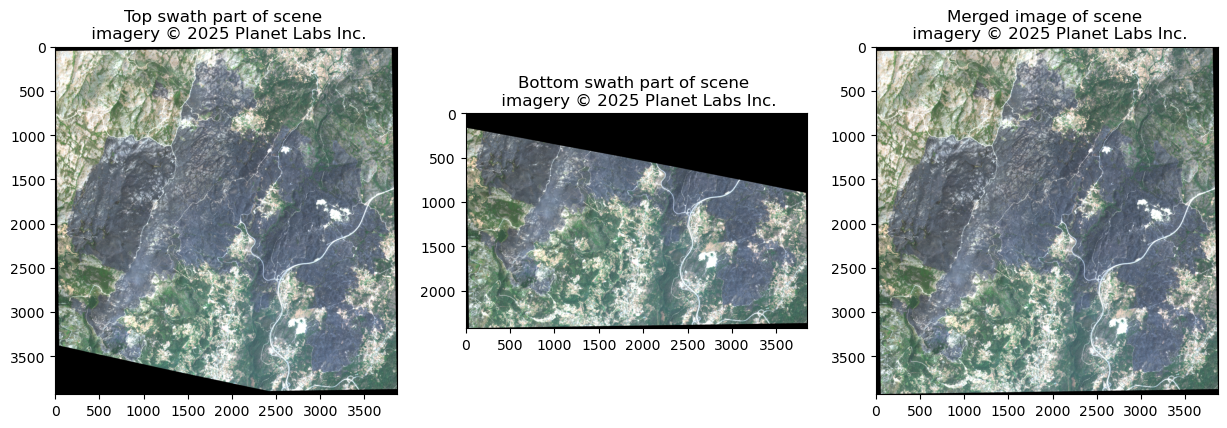

In [ ]:
# plot the two swath pathes as well as the merged image

# Open the raster file
with rasterio.open(image_path_one) as src:
    # Read the bands as R G B NIR
    swath_img_one = src.read([3,2,1,4])
    
# Open the raster file
with rasterio.open(image_path_two) as src:
    # Read the bands as R G B NIR
    swath_img_two = src.read([3,2,1,4])
    
# Open the raster file
with rasterio.open(f"{output}/{output_name}.tif") as src:
    # Read the bands as R G B NIR
    merged_img = src.read([3,2,1,4])        

fig, axes = plt.subplots(1,3, figsize=(3*5, 5))
axes[0].imshow(np.transpose(contrast_stretch(swath_img_one), (1, 2, 0))[:,:,[0,1,2]])
axes[0].set_title("Top swath part of scene \n Imagery © 2025 Planet Labs Inc.")
axes[1].imshow(np.transpose(contrast_stretch(swath_img_two), (1, 2, 0))[:,:,[0,1,2]])
axes[1].set_title("Bottom swath part of scene \n Imagery © 2025 Planet Labs Inc.")
axes[2].imshow(np.transpose(contrast_stretch(merged_img), (1, 2, 0))[:,:,[0,1,2]])
axes[2].set_title("Merged image of scene \n Imagery © 2025 Planet Labs Inc.")

## Read and stretch the satellite image

In [14]:
# path to the satellite image (image should be in .tif format)
tif = f"{output}/{output_name}.tif"

# Open the raster file
with rasterio.open(tif) as src:
    # Read the bands as R G B NIR
    image = src.read([3,2,1,4])  
    
# Apply contrast stretching similar to QGIS's automatic adjustment (2%-98%)
stretched_image = contrast_stretch(image)
# Transpose the array for plotting (matplotlib expects (height, width, channels))
stretched_image = np.transpose(stretched_image, (1, 2, 0))
# save the transform of original image
transform_to_use = src.transform
# save CRS (Coordinate Reference System) of original image
crs_to_use = src.crs  # Example with WGS84

## Plot the satellite images

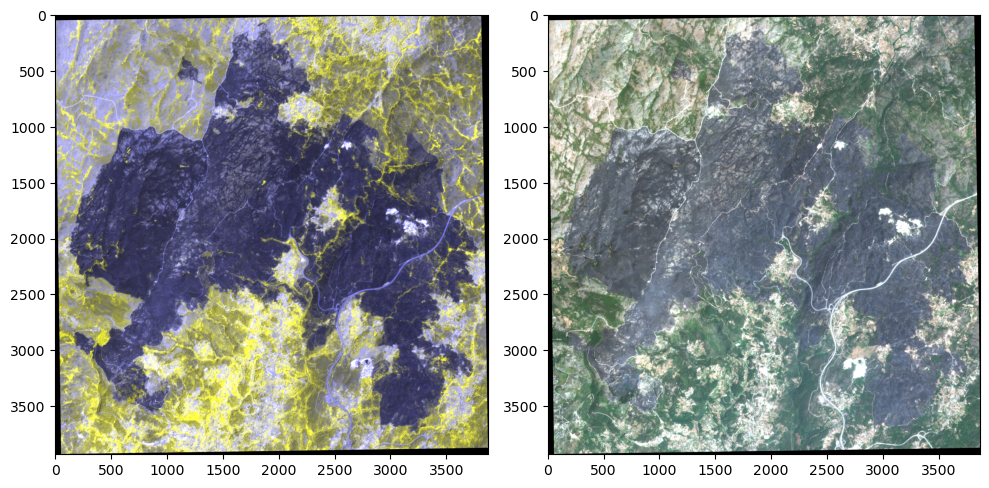

In [21]:
# Create a figure with two subplots next to each other. 
# This way, two different band combinations can be displayed 
fig, axes = plt.subplots(1,2, figsize=(2*5, 5))

# plot the two images with the defined band combination
# Change the combination in the [] according to your needs
# 0 = Red, 1 = Blue, 2 = Green, 3 = NIR
# plot NIR NIR R
axes[0].imshow(stretched_image[:,:,[3,3,0]])
# plot RGB
axes[1].imshow(stretched_image[:,:,[0,1,2]])
# display the plots
plt.tight_layout()

# if wanted, save the image to the specified path
#fig.savefig('PATH_TO_SAVE_THE_IMAGE/NAME_OF_IMAGE.png', dpi=300, bbox_inches='tight')

## Mask borders and set them to 255. Smooth the image with a uniform filter and plot the result.

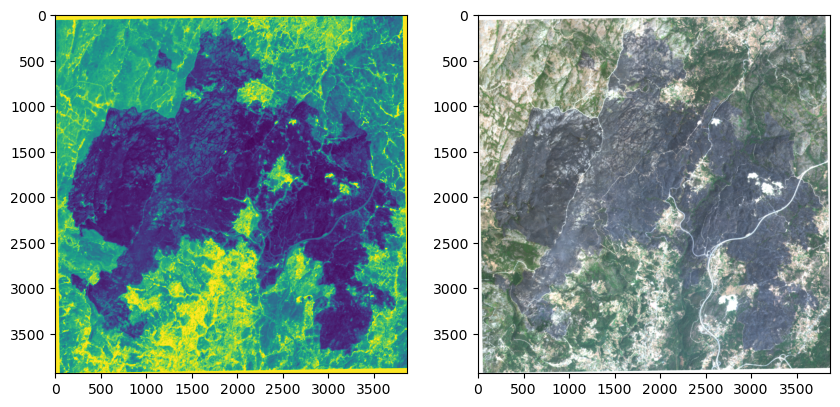

In [22]:
# remove problematic 0 values and set them to the max value
mask_zero = stretched_image[:,:,3] == 0
stretched_image[mask_zero] = 255

# Parameters for uniform filter
sigma = 5 # Controls the amount of smoothing

# Apply uniform filter to each band
# this smoothes thes images slightly
blurred_image = np.empty_like(stretched_image)
for i in range(stretched_image.shape[2]):
    blurred_image[:, :, i] = ndi.uniform_filter(stretched_image[:, :, i], size=sigma)
    
# Plot the smoothed image    
fig, axes = plt.subplots(1,2, figsize=(2*5, 5))
axes[0].imshow(blurred_image[:,:,3])
axes[1].imshow(blurred_image[:,:,[0,1,2]])

## Separate burned area using thresholds on the NIR band

We aim to separate the burned area from the surroundings by using thresholds on the defined band.
It is recommended to use the NIR band, since it mostly allows good separations. 
Burned surface will normally appear darker than their surroundings, displaying lower values in the NIR band. Depending on clouds, smoke and vegetation, different
thresholds have to be chosen for different scenes. 

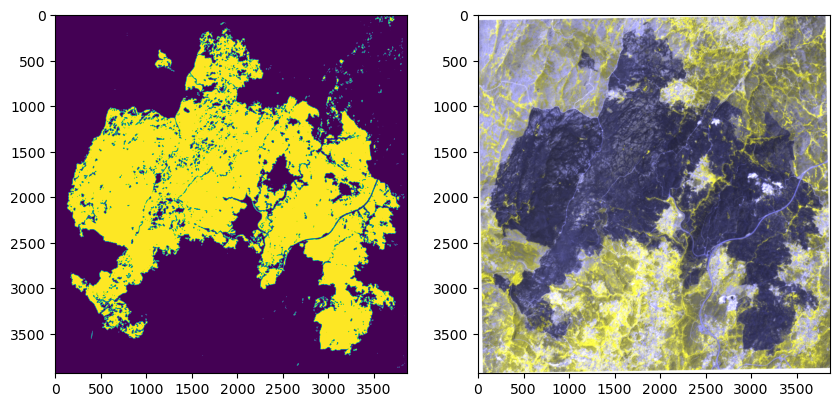

In [27]:
# Set threshold and band, on which the threshold is applied
threshold = 100 # threshold above which everything is set to 0. Needs to be chosen scene dependent. Max value is 255 due to stretching.
chosen_band = 3 # NIR-band. Other bands can be chosen as well

# create a mask according to the threshold on the specified band
mask_ba = np.logical_and(blurred_image[:,:,chosen_band]<threshold, blurred_image[:,:,chosen_band]>0)
# create masked image and set everything below the threshold to 1 and everything else to 0
# The threshold needs to be adapted to ensure best possible separation of burned area and surroundings
blurred_image_masked = blurred_image[:,:,0].copy()
blurred_image_masked[~mask_ba] = 0
blurred_image_masked[mask_ba] = 1

# plot the binary image with burned area (1) and surroundings (0) and adjust the threshold, 
# if you are not satisfied with the visible separation.
# The original image is plotted right next to the binary separation for validation.
fig, axes = plt.subplots(1,2, figsize=(2*5, 5))
axes[0].imshow(blurred_image_masked)
axes[1].imshow(blurred_image[:,:,[3,3,0]])

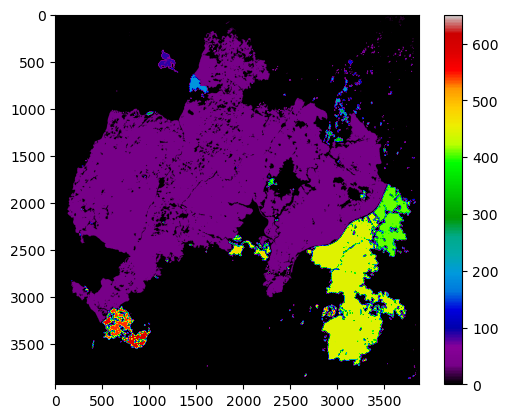

In [28]:
# Separate coherent clusters below the chosen threshold. ALl pixels of a cluster will have the same number.
# other areas might have values below the chosen threshold as well.
# Nevertheless, they are mostly not connected to the burned area and can be removed using the specific cluster number
labeled_array, num_features = ndi.label(blurred_image_masked)

# plot the cluster with a legend indicating the number of each cluster
plt.imshow(labeled_array, cmap='nipy_spectral')
plt.colorbar()
plt.show()

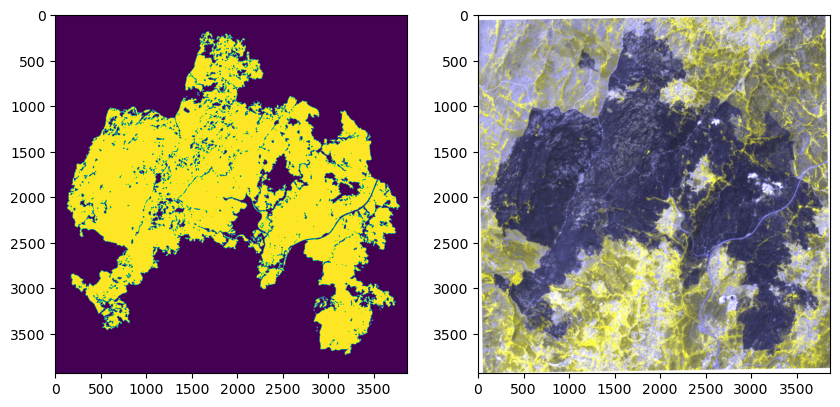

In [33]:
# identify and select all clusters that belong to the burned area
cluster_to_connect = np.concatenate([np.unique(labeled_array[750:2500,800:2350])])
cluster_to_connect = np.concatenate([cluster_to_connect,np.unique(labeled_array[3300:3350,550:600])]) 
cluster_to_connect = np.concatenate([cluster_to_connect,np.unique(labeled_array[2000:3500,2800:3600])])                      
cluster_with_burned_area = cluster_to_connect[np.where(cluster_to_connect != 0)]

# create a mask that includes only the relevant clusters
mask_all = np.isin(labeled_array, cluster_with_burned_area)
# set every other cluster to 0.
# The result should be a binary matrix, 
# in which the burned area has the value 1 and the rest the value 0
burned_area = blurred_image_masked.copy()
burned_area[~mask_all] = 0
burned_area[mask_all] = 1

# plot the resulting burned area and compare to the real image to spot differences and problems
fig, axes = plt.subplots(1,2, figsize=(2*5, 5))
axes[0].imshow(burned_area)
axes[1].imshow(blurred_image[:,:,[3,3,0]])

## Create a new GeoDataframe, which only contains the burned area

Use the binary matrix to create a new geometry according to the src and the transformation of the original image. 
Apply a concave hull to create a detailed outline of the burned area, closing potential holes in the polygon.
Convert the concave hull to a GeoDataFrame

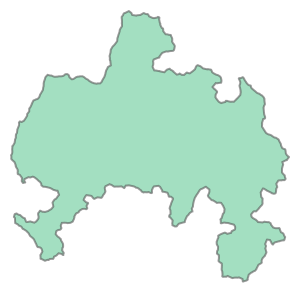

In [38]:
# create a new GeoDataFrame from the sparated burned area
mask = burned_area == 1  # Create a mask for the values of 1
# collect the necessary results for the new geometry
results = (
    {'properties': {'raster_val': v}, 'geometry': s}
    for j, (s, v) in enumerate(
        shapes((burned_area).astype(int), mask=mask, transform=transform_to_use)))

# create the new geometry
geoms = list(results)
gdf_ba = geo.GeoDataFrame.from_features(geoms)
gdf_ba = gdf_ba[gdf_ba['raster_val'] == 1]  # Keep only the geometries where raster_val is 1
# Set the CRS for the new GeoDataFrame to match the original raster
gdf_ba = gdf_ba.set_crs(crs_to_use, inplace=False)

# a concave hull is now created to close potential holes in the GeoDataFrame 
# and create an outline as close to the real burned area as possible

# select all geometry supporting points 
all_points = []
for i in geoms:
    all_points.extend(i.get("geometry").get("coordinates")[0])

# Use these points to calculate the concave hull with the alphashape function of the same package.
# The alpha value needs to be adjusted according to the details and complexity of the burned area. 
# Different values should be tried to find the best one for your needs.
alpha = 0.01
concave_hull = alphashape.alphashape(all_points, alpha)
concave_hull

In [39]:
# Create a GeoDataFrame from this convex hull
final_burned_area_gdf = geo.GeoDataFrame(geometry=[concave_hull])
final_burned_area_gdf = final_burned_area_gdf.set_crs(src.crs, inplace=True)

## Save the GeoDataFrame

In [ ]:
# save the GeoDataFrame as a shapefile
final_burned_area_gdf.to_file(PATH_TO_SAVE_SHAPEFILE/NAME_OF_SHAPEFILE.shp)